In [1]:
%matplotlib notebook
import numpy as np
import finufft
import matplotlib.pyplot as plt
import scipy as sc

# Frequency spectra and moments from non-uniform samples


<IPython.core.display.Javascript object>


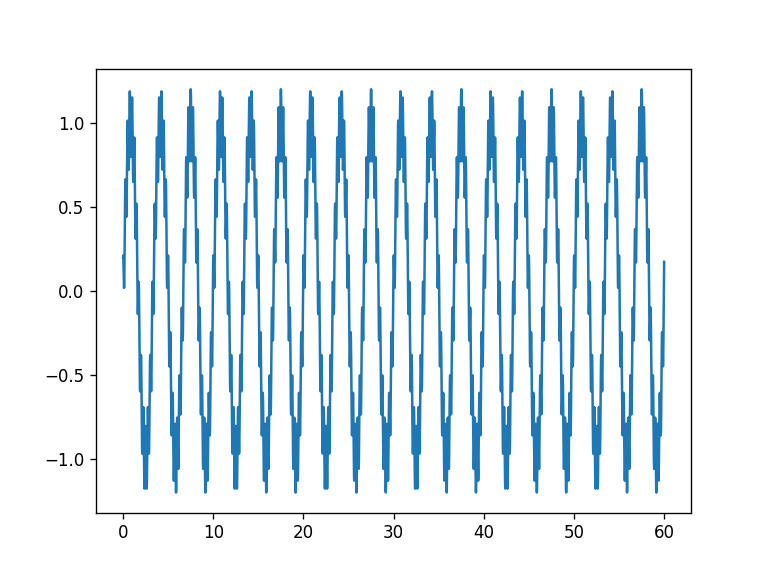

In [2]:
# Known synthetic data

dt = 0.01
Fs = 1 / dt
x = np.arange(0,60,0.01)

def S(x):
    return np.sin(0.3*2*np.pi*x) + 0.2 * np.cos(4*2*np.pi*x)

s = S(x)

plt.figure()
plt.plot(x, s)

<IPython.core.display.Javascript object>


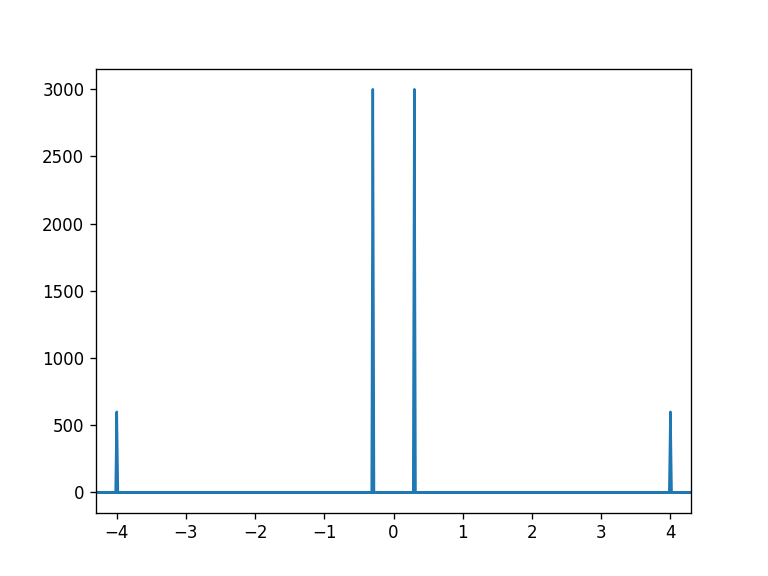

(-4.3, 4.3)

In [3]:
# Calculate spectra
Pxx = np.abs(np.fft.fft(s))
f = np.fft.fftfreq(len(s), dt)
plt.figure()
plt.plot(f, Pxx)
plt.xlim([-4.3, 4.3])

# We expect peaks at 0.3 and 4 Hz

<IPython.core.display.Javascript object>


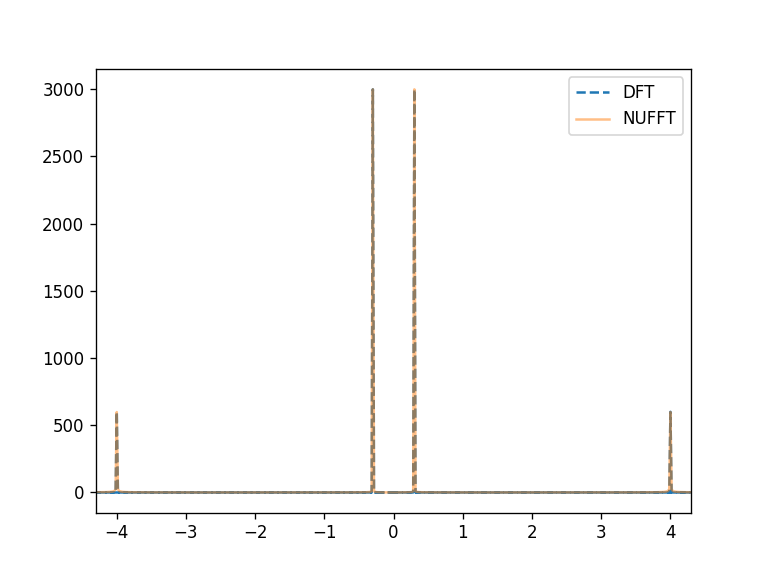

(-4.3, 4.3)

In [4]:
# Let's try and produce the same result using the uniform samples with the non-uniform FFT

# Rescale coordinates to interval [0, 2*np.pi]
xx = x / np.max(x) * 2*np.pi # x starts at zero, otherwise needs to be offset as well.

h = finufft.nufft1d1(xx, s.astype('complex128'), n_modes=len(s), isign=-1, eps=1e-6, upsampfac=1.25)

# Note: FINUFFT returns the output with lower frequencies at center (as opposed to numpy / DFT).
fh = np.fft.fftshift(f)

plt.figure()
plt.plot(f, Pxx, '--', label='DFT')
plt.plot(fh, np.abs(h), alpha=0.5, label='NUFFT')
plt.legend()
plt.xlim([-4.3, 4.3])

# Looks pretty good.

<IPython.core.display.Javascript object>


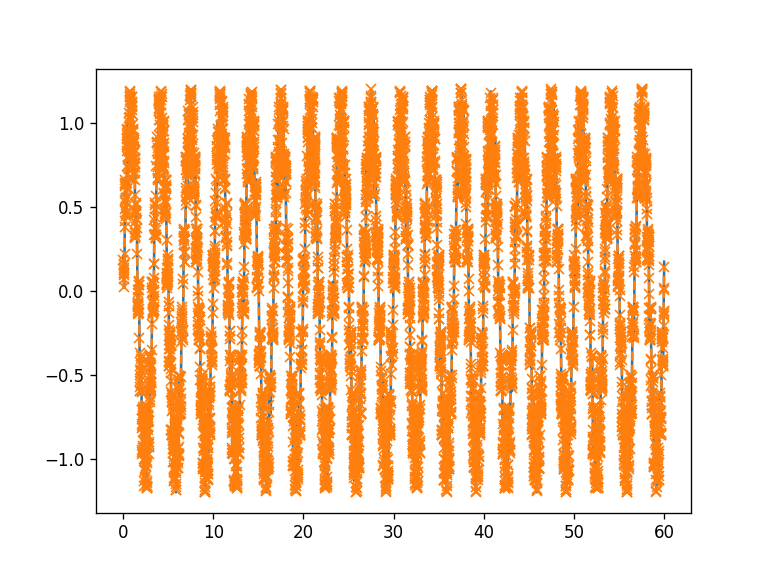

In [5]:
# Now sample the function randomly
xr = np.sort(np.max(x) * np.random.random_sample((len(s),)))
sr = S(xr)

plt.figure()
plt.plot(x, s, label='uniform')
plt.plot(xr, sr, '--x', label='random')

<IPython.core.display.Javascript object>


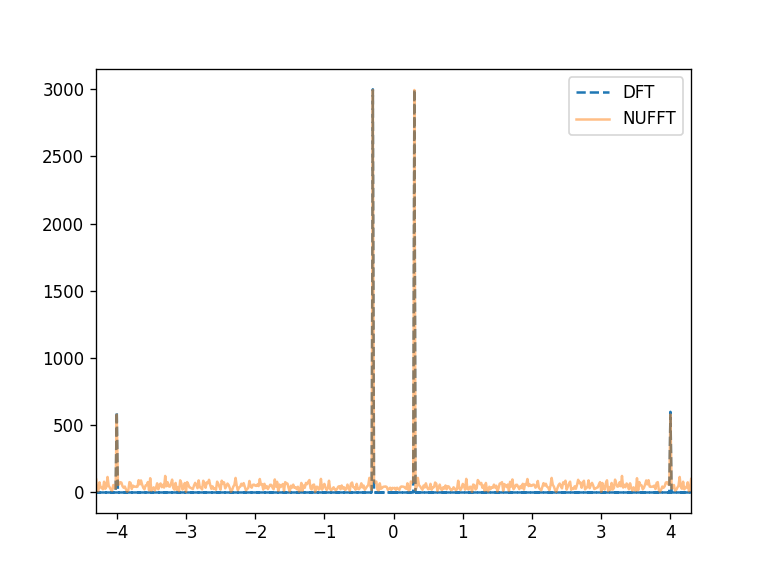

(-4.3, 4.3)

In [6]:
# Let's try to make a spectra from that!

# Rescale coordinates to interval [0, 2*np.pi]
xxr = xr / np.max(xr) * 2*np.pi # x starts at zero, otherwise needs to be offset as well.

hr = finufft.nufft1d1(xxr, sr.astype('complex128'), n_modes=len(sr), isign=-1, eps=1e-6, upsampfac=1.25)

plt.figure()
plt.plot(f, Pxx, '--', label='DFT')
plt.plot(fh, np.abs(hr), alpha=0.5, label='NUFFT')
plt.legend()
plt.xlim([-4.3, 4.3])

## Not half bad!

Ok, now lets try with regularily missing segments...

<IPython.core.display.Javascript object>


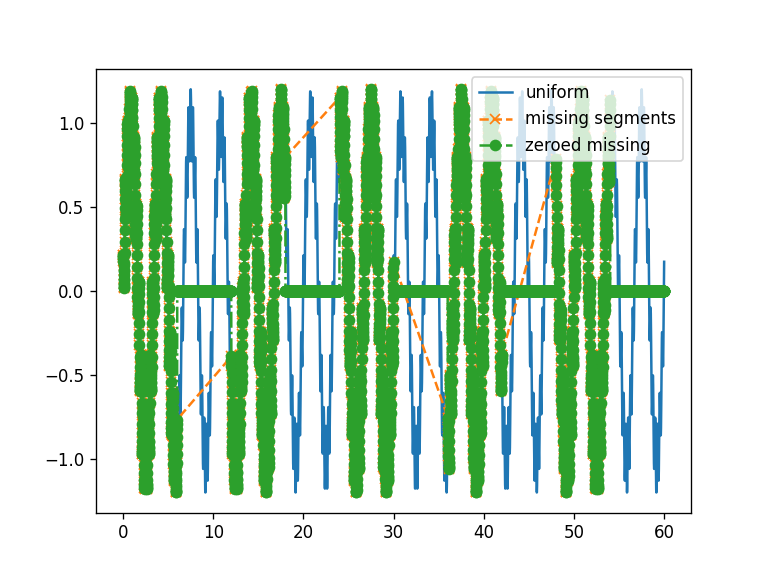

In [7]:
# discarding some data indexes regularly
all_indexes = np.split(np.arange(0, x.size, 1), 10)
selected_indexes = all_indexes[::2]
concatenated_indexes = np.concatenate(selected_indexes)

# series without missing data
xc = x[concatenated_indexes]
sc = S(xc)

# series with missing data zeroed out
sz = np.zeros((x.size,))
sz[concatenated_indexes] = S(x[concatenated_indexes])

plt.figure()
plt.plot(x, s, label='uniform')
plt.plot(xc, sc, '--x', label='missing segments')
plt.plot(x, sz, '-.o', label="zeroed missing")
plt.legend()

1.0


<IPython.core.display.Javascript object>


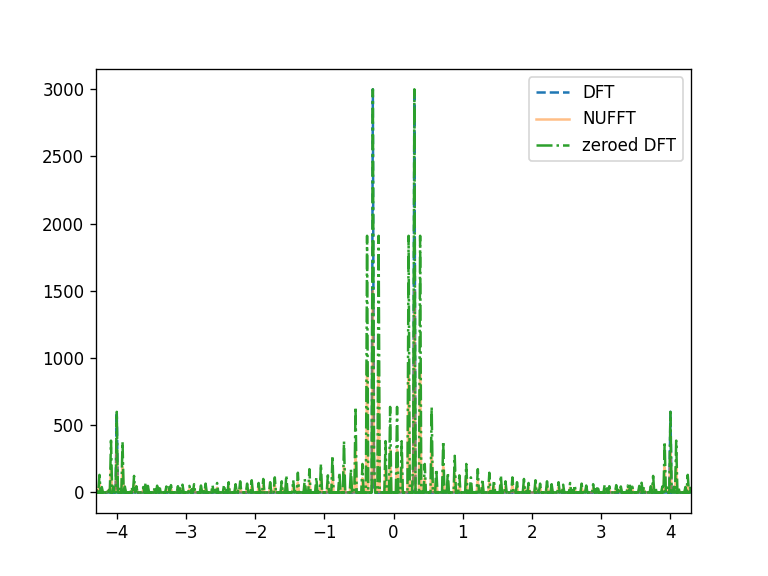

In [8]:
# Let's try to make a spectra from that!

##########
# from the series without the missing data using non uniform fft

# Rescale coordinates to interval [0, 2*np.pi]
xxc = xc / np.max(x) * 2*np.pi # x starts at zero, otherwise needs to be offset as well.

hc = finufft.nufft1d1(xxc, sc.astype('complex128'), n_modes=len(s), isign=-1, eps=1e-6, upsampfac=1.25)

# Scale with difference in samples
k = len(x)/len(x)
print(k)

##########
# from the series with the missing data zeroed out

# this is not really non-uniform; this is uniform with holes
# so, taking FFT should work, applying relevant scaling

Pxxz = np.abs(np.fft.fft(sz))
fz = np.fft.fftfreq(len(sz), dt)
scaling = float(x.size) / concatenated_indexes.size
Pxxz = Pxxz * scaling

##########

plt.figure()
plt.plot(f, Pxx, '--', label='DFT')
plt.plot(fh, k*np.abs(hc), alpha=0.5, label='NUFFT')
plt.plot(fz, Pxxz, '-.', label='zeroed DFT')
plt.legend()
plt.xlim([-4.3, 4.3])

plt.show()

<IPython.core.display.Javascript object>


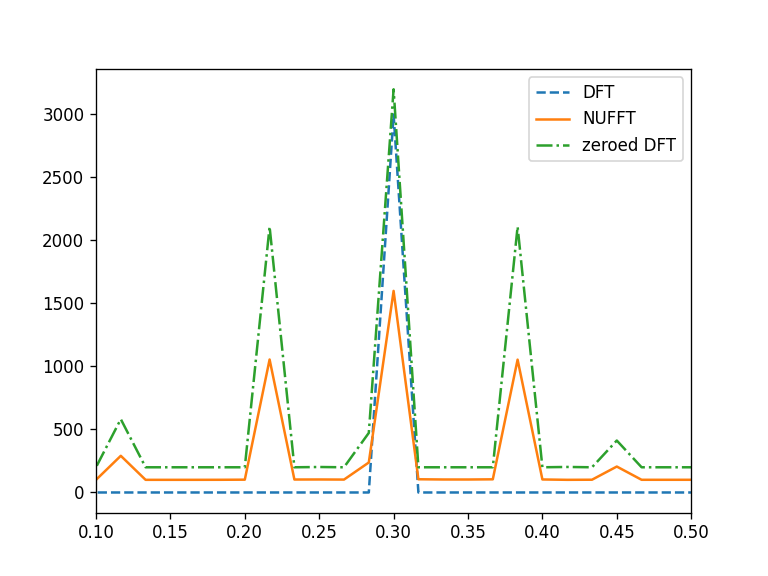

In [9]:
# just to show that, except for the Gibbs phenomena due to the missing data,
# the DFT and the zeroed DFT are identical

epsilon = 100  # better display

# when zooming on, only show on [0: f.size // 2 -1]
# so that avoid the "double line" effect due to f and fz being non monotonic
plt.figure()
plt.plot(f[0: f.size // 2 -1], Pxx[0: f.size // 2 -1], '--', label='DFT')
plt.plot(fh, k*np.abs(hc) + epsilon, label='NUFFT')
plt.plot(fz[0: f.size // 2 -1], Pxxz[0: f.size // 2 -1] + 2.0 * epsilon, '-.', label='zeroed DFT')
plt.legend()
plt.xlim([0.1, 0.5])
plt.show()

Alright!

1.8544847623168692


<IPython.core.display.Javascript object>


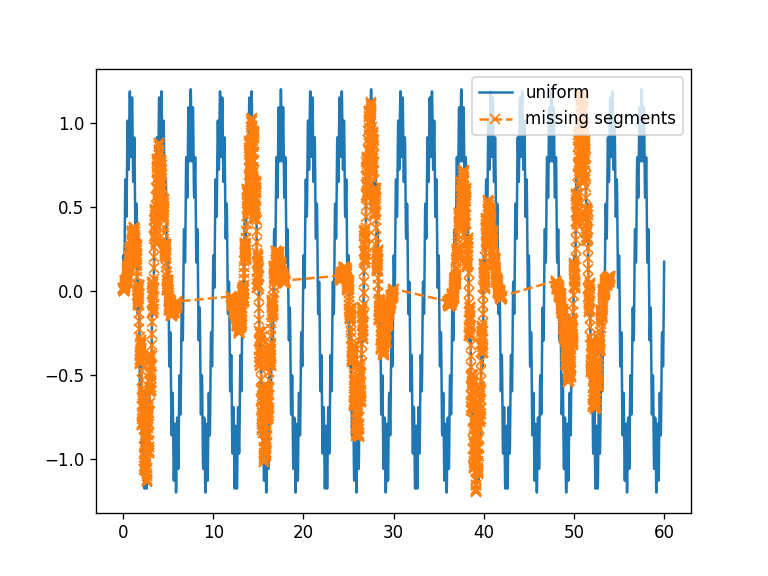

In [10]:
# Apply Hamming-window to chunks

xc2 = np.split(x, 10)
xc2 = xc2[::2]
sc2 = [np.hamming(len(_xc)) * S(_xc) for _xc in xc2]

wk = 1./(np.sum(np.hamming(len(xc2[0])))/len(xc2[0]))
print(wk)

xc2 = np.concatenate(xc2)
sc2 = np.concatenate(sc2)

plt.figure()
plt.plot(x, s, label='uniform')
plt.plot(xc2, sc2, '--x', label='missing segments')
plt.legend()

2.0


<IPython.core.display.Javascript object>


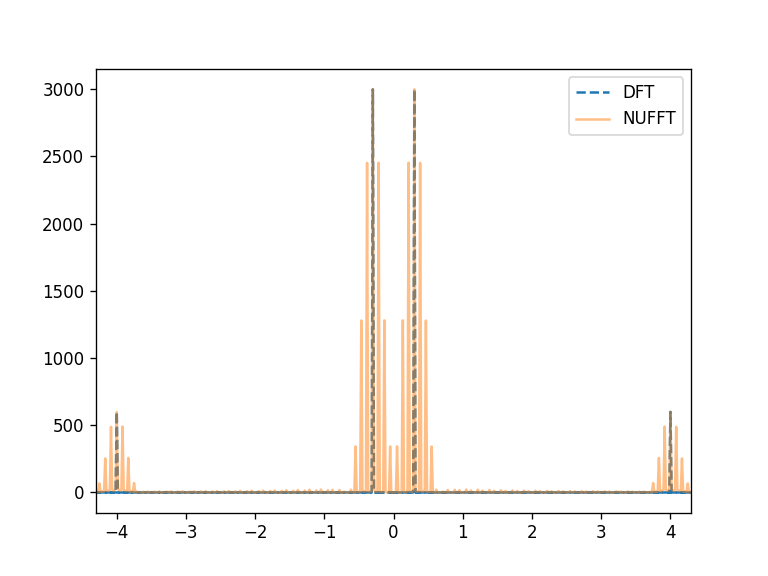

(-4.3, 4.3)

In [11]:
# Let's try to make a spectra from that!

# Rescale coordinates to interval [0, 2*np.pi]
xxc2 = xc2 / np.max(x) * 2*np.pi # x starts at zero, otherwise needs to be offset as well.

hc2 = finufft.nufft1d1(xxc2, sc2.astype('complex128'), n_modes=len(s), isign=-1, eps=1e-6, upsampfac=1.25)

# Scale with difference in samples
k2 = len(x)/len(xc2)
print(k2)

plt.figure()
plt.plot(f, Pxx, '--', label='DFT')
plt.plot(fh, wk*k2*np.abs(hc2), alpha=0.5, label='NUFFT')
plt.legend()
plt.xlim([-4.3, 4.3])